In [13]:
# data prepare
import glob,re,os,sys
os.chdir('C:/kongjy_special/实习工作内容总结/201805-201808华泰证券/Task4/')
sys.path.append('C:\\kongjy_special\\实习工作内容总结\\201805-201808华泰证券\\Task4')
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import TranFeature,Tools_kjy
import warnings

warnings.filterwarnings('ignore')
pd.options.display.width = 200

# 文件名
TickNameList = glob.glob('Java_log_orders_600519/Tick*.csv')
TranNameList = glob.glob('Java_log_orders_600519/Tran*.csv')
# TestName是 开平仓点 的csv，需要和Tick以及Tran保持时间对齐
DateList = [re.search('\d{8}',i)[0] for i in TickNameList if re.search('\d{8}',i)]  
TestNameFun = lambda x: "Java_log_orders_600519\\600519.SH_back_test_info_" + x +".csv"
TestNameList = [TestNameFun(i) for i in DateList]
print (TickNameList[0])
print (TranNameList[0])
print (TestNameList[0])


Java_log_orders_600519\Tick20180502.csv
Java_log_orders_600519\Tran20180502.csv
Java_log_orders_600519\600519.SH_back_test_info_20180502.csv


In [55]:

# 收集所有数据
DataSave = pd.DataFrame()
# 数据读入 和 预处理
for date_index in range(len(TickNameList))[3:4]:
    date = re.search('\d{8}',TickNameList[date_index])[0]
    tempTick = pd.read_csv(TickNameList[date_index])
    tempTran = pd.read_csv(TranNameList[date_index])
    tempTest = pd.read_csv(TestNameList[date_index])
    # Tick数据处理
    tempTick = tempTick.rename(columns={"Unnamed: 0":"Timestamp"})
    tempTick['Timestamp'] = pd.to_datetime(tempTick['Timestamp'])
    tempTick['median_5'] = (tempTick['AskP0'].rolling(window=5).median()).shift(-2).fillna(method='pad')
    tempTick['median_5'],_ = Tools_kjy.smooth(tempTick['median_5'])
    # 开平仓点提取
    tickindex = tempTest[tempTest.order != " "].index
    print ("Date : %s with %s data"%(date,len(tickindex)))
    # # Tran 数据处理
    tempTran = tempTran.rename(columns={"Unnamed: 0":"Timestamp"})
    tempTran['Timestamp'] = pd.to_datetime(tempTran['Timestamp'])
    FeatureTran = TranFeature.TranFeature(tempTran,tempTick)
    tempTick = FeatureTran._Tran_features()
#     tempTick = FeatureTran._Tran_energy()
    
    # past change
    def past_change(x):
        tempTick['Past_diff'+str(x)] = tempTick['AskP0'].diff(x).fillna(0)
    past_change(1);past_change(2);past_change(3);past_change(4);past_change(5);past_change(6)

    # future change
    tempTick['diff_3Tick'] = tempTick['AskP0'].diff(3).shift(-3).fillna(0)
    tempTick['diff_1Tick'] = tempTick['AskP0'].diff(1).shift(-1).fillna(0)
    tempTick['isadd_3Tick'] = tempTick['diff_3Tick'].apply(Tools_kjy.trinary)
    tempTick['isadd_1Tick'] = tempTick['diff_1Tick'].apply(Tools_kjy.trinary)

    # 开平仓点保存
    DataSave = DataSave.append(tempTick.loc[tickindex,:])
    
 
print ('done!')
DataSave = DataSave.reset_index(drop=True)

Date : 20180507 with 122 data
done!


In [58]:
# 几种价格的std  ，在上面_Tran_energy 出已经生成了交易价格的熵(TickEntrophy  )和温度(MedianV_price)
def addstd(DataSave):
    DataSave['std5Price'] = DataSave[['HighPrice','LowPrice','MedianPrice','MedianBid','MedianAsk','AskP0']].apply(np.std,axis=1)
addstd(DataSave)
print (DataSave[['HighPrice','LowPrice','MedianPrice','MedianBid','MedianAsk','AskP0','std5Price','diff_3Tick','diff_1Tick']].head(20),'\n')


    HighPrice  LowPrice  MedianPrice  MedianBid  MedianAsk   AskP0  std5Price  diff_3Tick  diff_1Tick
0      661.65    661.01      661.650    661.650    661.010  661.64   0.300541       -0.64       -0.64
1      661.64    661.00      661.010    661.325    661.010  661.00   0.242803       -0.09        0.00
2      661.00    660.94      661.000    661.000    660.940  661.00   0.028284       -0.09        0.00
3      660.91    660.90      660.910    660.910    660.910  661.00   0.034480       -0.39       -0.09
4      660.91    660.66      660.910    660.910    660.660  660.91   0.117851       -0.31       -0.30
5      657.95    657.80      657.800    657.800    657.950  657.95   0.075000        0.00       -0.15
6      657.95    657.77      657.800    657.875    657.770  657.80   0.065048        0.62        0.00
7      657.80    657.77      657.800    657.800    657.800  657.80   0.011180        0.62        0.15
8      658.42    657.80      657.950    658.020    657.800  657.95   0.208646     

In [59]:
DataSave['diff_3Tick'] = DataSave['diff_3Tick'].clip(-1.0,1.0)
DataSave['diff_1Tick'] = DataSave['diff_1Tick'].clip(-0.3,0.3)

In [64]:
# std较小的时候，价格的变化
check1 = DataSave['std5Price'].nsmallest(20).index  
print (DataSave.loc[check1,['std5Price','Turnover','AskP0','MedianBid','MedianAsk','Past_diff1','Past_diff2','Past_diff3','diff_3Tick','diff_1Tick']].head(10))

# print ('std较小的时候，diff_3Tick的变化:\n',DataSave.loc[check1,'diff_3Tick'].describe(),'\n')
# print ('std较小的时候，diff_1Tick的变化:\n',DataSave.loc[check1,'diff_1Tick'].describe(),'\n')
# print ('std较小的时候，Past_diff1的变化:\n',DataSave.loc[check1,'Past_diff1'].describe(),'\n')

# std较大的时候，价格的变化
check2 = DataSave['std5Price'].nlargest(20).index 
print (DataSave.loc[check2,['CountAsk','CountBid','AskP0','MedianBid','MedianAsk','Past_diff1','Past_diff2','Past_diff3','diff_3Tick','diff_1Tick']].head(10))

# print ('std较大的时候，diff_3Tick的变化:\n',DataSave.loc[check2,'diff_3Tick'].describe(),'\n')
# print ('std较大的时候，diff_1Tick的变化:\n',DataSave.loc[check2,'diff_1Tick'].describe(),'\n')
# print ('std较大的时候，Past_diff1的变化:\n',DataSave.loc[check2,'Past_diff1'].describe(),'\n')

     std5Price   Turnover   AskP0  MedianBid  MedianAsk  Past_diff1  Past_diff2  Past_diff3  diff_3Tick  diff_1Tick
30    0.000000    66489.0  664.89     664.89     664.89        0.00        0.19        0.19        0.11        0.07
71    0.003727    67829.0  678.30     678.29     678.29        0.00        0.00        0.00       -0.07       -0.01
78    0.003727   203403.0  678.02     678.01     678.01       -0.10       -0.12       -0.14       -0.01        0.26
121   0.004488   617857.0  686.51     686.51     686.50       -0.02       -0.04       -0.06       -0.01       -0.01
95    0.004714  1966776.0  678.20     678.20     678.19        0.00        0.21        0.23        0.30        0.12
110   0.004714  1849767.0  685.10     685.10     685.09        0.00        0.09        0.16        0.23        0.15
99    0.006872  3479910.0  681.01     681.00     681.00        0.02        0.03        0.03        0.10        0.04
38    0.007454   600285.0  666.98     666.98     666.98        0.00     

In [22]:
tempTick['std5Price'] = tempTick[['HighPrice','LowPrice','MedianPrice','MedianBid','MedianAsk','Price']].apply(np.std,axis=1) * 100
tempTick.std5Price.describe()

count    4730.000000
mean        5.543683
std         8.687384
min         0.000000
25%         0.093169
50%         2.307144
75%         7.277128
max       110.000000
Name: std5Price, dtype: float64

    Price  PriceShift1  std5Price  Past_diff1  diff_3Tick  diff_1Tick
0  661.69          NaN  93.809500        0.00        1.00        0.00
1  661.69          NaN  78.724555        0.00        1.00        0.30
2  662.00          NaN  11.553018        0.31        0.88        0.30
3  662.87          NaN  69.090922        0.87        0.00        0.00
4  662.87          NaN   0.000000        0.00        0.01        0.01 



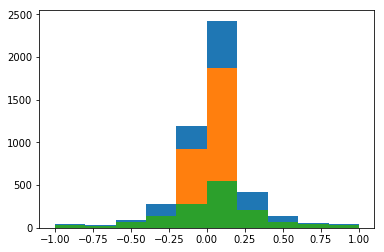

In [23]:
tempTick['diff_1Tick'] = tempTick['diff_1Tick'].clip(-0.3,0.3)
tempTick['diff_3Tick'] = tempTick['diff_3Tick'].clip(-1.0,1.0)
print (tempTick.loc[:,['Price','PriceShift1','std5Price',\
                            'Past_diff1','diff_3Tick','diff_1Tick']].head(),'\n')

check1 = tempTick[tempTick['std5Price'] < tempTick['std5Price'].mean()].index 
check2 = tempTick[tempTick['std5Price'] > tempTick['std5Price'].mean()].index 
# print (tempTick.diff_3Tick.value_counts(bins=20,sort=False))
# print (tempTick.loc[check1,'diff_3Tick'].value_counts(bins=20,sort=False))
plt.hist(tempTick.loc[:,'diff_3Tick'])
plt.hist(tempTick.loc[check1,'diff_3Tick'])
plt.hist(tempTick.loc[check2,'diff_3Tick'])
plt.show()

In [24]:
# 选点个std5Price 较小的区域
check_std5_S = tempTick.std5Price.nsmallest(400).index
print (tempTick.loc[check_std5_S,['PriceTempera','Price','Past_diff1','Past_diff2','Past_diff3','diff_1Tick','diff_3Tick','CountPrice']].head(20))

     PriceTempera   Price  Past_diff1  Past_diff2  Past_diff3  diff_1Tick  diff_3Tick  CountPrice
4             NaN  662.87        0.00        0.87        1.18        0.01        0.01         2.0
32            NaN  660.00        0.00       -1.00       -1.99        0.10        1.00         NaN
35            NaN  661.00        0.00        0.90        1.00        0.30       -0.85         1.0
62            NaN  661.52       -0.05       -0.18       -0.10        0.25        0.18         1.0
77            NaN  662.50        0.52        0.50        0.67       -0.30       -0.85         2.0
80            NaN  661.65        0.00       -0.35       -0.85       -0.30       -0.65         4.0
88            NaN  660.66       -0.25       -0.25       -0.24       -0.05       -0.34         5.0
125           NaN  658.00        0.00        0.00        0.00        0.11        0.00        12.0
127           NaN  658.25        0.14        0.25        0.25       -0.25        0.00         2.0
148           NaN  6

In [29]:
# std5Price 对价格变化的影响
%matplotlib qt5
plt.plot(tempTick.std5Price)
plt.twinx()
plt.plot(tempTick.Price,c='r')
plt.show()

In [27]:
# entrophy 对价格变化的影响
%matplotlib qt5
plt.plot(tempTick.TickEntrophy)
plt.twinx()
plt.plot(tempTick.Price,c='r')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'TickEntrophy'

In [32]:
check1 = tempTick.Price.nsmallest(200).index
plt.plot(check1,)